# Image Reduction in Python 

Erik Tollerud (STScI)

In this notebook we will walk through several of the basic steps required to do data reduction using Python and Astropy.  This notebook is focused on "practical" (you decide if that is a code word for "lazy") application of the existing ecosystem of Python packages.  That is, it is *not* a thorough guide to the nitty-gritty of how all these stages are implemented.  For that, see other lectures in this session.

## Installation/Requirements

This notebook requires the following Python packages that do not come by default with anaconda:

* CCDProc (>= v1.3)
* Photutils (>= v0.4)

Both if these should be available on the `astropy` (or `conda-forge`) channels.  So you can get them with conda by doing ``conda -c astropy ccdproc photutils``.

If for some reason this doesn't work, ``pip install <packagename>`` should also work for either package.

Regardless of how you install them, you may need to restart your notebook kernel to recognize the packages are present. Run the cells below to ensure you have the right versions.

In [1]:
import ccdproc
ccdproc.__version__

'1.3.0'

In [2]:
import photutils
photutils.__version__

'0.4'

We also do a few standard imports here python packages we know we will need.

In [3]:
from glob import glob

import numpy as np

from astropy import units as u


%matplotlib inline
from matplotlib import pyplot as plt

## Getting the data

We need to first get the image data we are looking at for this notebook. This is actual data from an observing run by the author using the Palomar 200" Hale Telescope, using the [Large Format Camera (LFC) instrument](http://www.astro.caltech.edu/palomar/observer/200inchResources/lfcspecs.html).  

The cell below will do just this from the web (or you can try downloading from here: https://northwestern.box.com/s/4mact3c5xu9wcveofek55if8j1mxptqd), and un-tar it locally to create a directory with the image files. This is an ~200MB download, so might take a bit. If the wifi has gotten bad, try asking a neighbor or your instructor if they have it on a key drive or similar.

In [ ]:
!wget http://www.stsci.edu/\~etollerud/python_imred_data.tar
!tar xf python_imred_data.tar

The above creates a directory called  "python_imred_data" - lets examine it:

In [8]:
ls -lh python_imred_data

total 746608
-rw-r--r--@  1 eileengonzales  staff    16M Jan 22 17:03 ccd.001.0.fits
-rw-r--r--@  1 eileengonzales  staff   6.4M Jan 21 01:56 ccd.001.0.fits.gz
-rw-r--r--@  1 eileengonzales  staff    16M Jan 22 17:03 ccd.002.0.fits
-rw-r--r--@  1 eileengonzales  staff   6.8M Jan 21 01:56 ccd.002.0.fits.gz
-rw-r--r--@  1 eileengonzales  staff    16M Jan 22 17:03 ccd.003.0.fits
-rw-r--r--@  1 eileengonzales  staff   6.7M Jan 21 01:56 ccd.003.0.fits.gz
-rw-r--r--@  1 eileengonzales  staff    16M Jan 22 17:03 ccd.004.0.fits
-rw-r--r--@  1 eileengonzales  staff   6.7M Jan 21 01:56 ccd.004.0.fits.gz
-rw-r--r--@  1 eileengonzales  staff    16M Jan 22 17:03 ccd.005.0.fits
-rw-r--r--@  1 eileengonzales  staff   6.6M Jan 21 01:56 ccd.005.0.fits.gz
-rw-r--r--@  1 eileengonzales  staff    16M Jan 22 17:03 ccd.006.0.fits
-rw-r--r--@  1 eileengonzales  staff   6.6M Jan 21 01:56 ccd.006.0.fits.gz
-rw-r--r--@  1 eileengonzales  staff    16M Jan 22 17:03 ccd.014.0.fits
-rw-r--r--@  1 eileengonzales  st

### Exercise 

Look at the ``observing_log.csv`` file - it's an excerpt from the log.  Now look at the file sizes above.  What patterns do you see?  Can you tell why? Discuss with your neighbor. (Hint: the ".gz" at the end is significant here.)

You might find it useful to take a quick look at some of the images with a fits viewer like `ds9` to do this.  Feel free to come back to this after looking over some of the files if you don't have an external prgram.

Answer:  Large files when unzipped, because they are fits files.

## Loading the data into Python

To have the "lowest-level" view of a fits file, you can use the `astropy.io.fits` package.  It is a direct view into a fits file, which means you have a lot of control of how you look at the file, but because FITS files can store more than just an individual image dataset, it requires some understanding of FITS files.  Here we take a quick look at one of the "science" images using this interface.

### Quick look with `astropy.io.fits`

In [10]:
from astropy.io import fits

data_g = fits.open('python_imred_data/ccd.037.0.fits.gz')
data_g

This shows that this file is a relatively simple image - a single "HDU" (Header + Data Unit). Lets take a look at what that HDU contains:

In [11]:
data_g[0].header

SIMPLE  =                    T  / STANDARD FITS                                 
BITPIX  =                   16  / BITS/PIXEL                                    
NAXIS   =                    2  / NUMBER OF AXES                                
NAXIS1  =                 2080  / NUMBER OF COLUMNS                             
NAXIS2  =                 4128  / NUMBER OF ROWS                                
BSCALE  =        1.0000000E+00  / PHYSICAL = BSCALE * DATA + BZERO              
BZERO   =               32768.                                                  
DATE    = '2016-01-16'          / UT Date of file creation (DD/MM/YY)           
ORIGIN  = 'California Institute of Technology'  / Palomar Observatory           
LATITUDE=              33.4000  / Latitude (degrees N)                          
LONGITUD=            -116.9000  / Longitude (degrees E)                         
TELESCOP= 'Hale 5m Telescope'   / Telescope used for observation                
FRATIO  =               7.50

In [12]:
data_g[0].data

array([[65535,  8304,  8758, ...,   962,   967,   971],
       [  963,  9819, 10651, ...,  1114,  1099,  1103],
       [ 1096, 10057, 10701, ...,  1114,  1110,  1113],
       ..., 
       [ 1104,  1356,  1350, ...,  1111,  1109,  1103],
       [ 1099,  1351,  1342, ...,  1098,  1101,  1105],
       [ 1103,  1366,  1351, ...,  1112,     0,     0]], dtype=uint16)

The `header` contains all the metadata about the image, while the `data` stores "counts" from the CCD (in the form of 16-bit integers). Seems sensible enough.  Now lets try plotting up those counts.

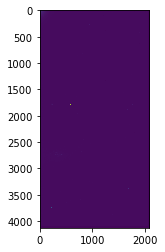

In [13]:
plt.imshow(data_g[0].data)

Hmm, not very useful, as it turns out.   

In fact, astronomical data tend to have dynamic ranges that require a bit more care when visualizing.  To assist in this, the `astropy.visualization` packages has some helper utilities for re-scaling an image look more interpretable (to learn more about these see [the astropy.visualization docs](http://docs.astropy.org/en/stable/visualization/)).

In [14]:
from astropy import visualization as aviz

/anaconda/envs/DSFP/lib/python3.6/site-packages/astropy/visualization/stretch.py:267: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/anaconda/envs/DSFP/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


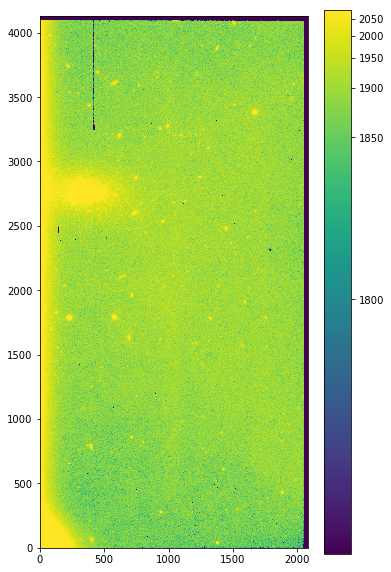

In [15]:
image = data_g[0].data
norm = aviz.ImageNormalize(image, 
                           interval=aviz.PercentileInterval(95), 
                           stretch=aviz.LogStretch())

fig, ax = plt.subplots(1,1, figsize=(6,10))
aim = ax.imshow(image, norm=norm, origin='lower')
plt.colorbar(aim)

Well that looks better. It's now clear this is an astronomical image.  However, it is *not* a very good looking one.  It is full of various kinds of artifacts that need removing before any science can be done.  We will address how to correct these in the rest of this notebook.

###  Exercise

Try playing with the parameters in the `ImageNormalize` class.  See if you can get the image to look clearer.  The [image stretching part of the docs](http://docs.astropy.org/en/stable/visualization/normalization.html) are your friend here!

/anaconda/envs/DSFP/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/anaconda/envs/DSFP/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


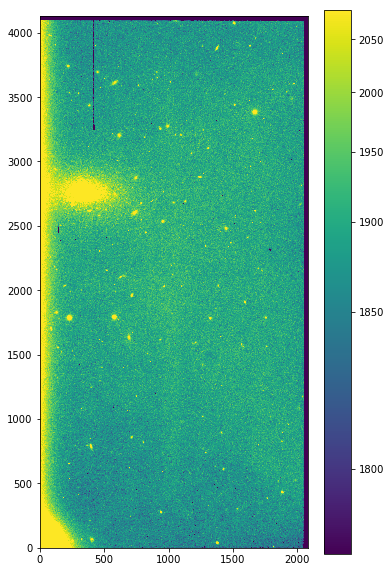

In [27]:
from astropy.visualization import SqrtStretch
stretch = SqrtStretch()  #stretched based on sqrt func.

image = data_g[0].data
norm = aviz.ImageNormalize(image, 
                           interval=aviz.PercentileInterval(95), 
                           stretch=stretch)

fig, ax = plt.subplots(1,1, figsize=(6,10))
aim = ax.imshow(image, norm=norm, origin='lower')
plt.colorbar(aim)

To simplify this plotting task in the future, we will make a helperfunction that takes in an image and scales it to some settings that seem to look promising.  Feel free to adjust this function to your preferences base on your results in the exercise, though!

In [44]:
def show_image(image, percl=99, percu=None, figsize=(6, 10)):
    """
    Show an image in matplotlib with some basic astronomically-appropriat stretching.
    
    Parameters
    ----------
    image
        The image to show 
    percl : number
        The percentile for the lower edge of the stretch (or both edges if ``percu`` is None)
    percu : number or None
        The percentile for the upper edge of the stretch (or None to use ``percl`` for both)
    figsize : 2-tuple
        The size of the matplotlib figure in inches
    """ 
    if percu is None:
        percu = percl
        percl = 100-percl
        
    norm = aviz.ImageNormalize(image, interval=aviz.AsymmetricPercentileInterval(percl, percu), 
                                      stretch=aviz.SqrtStretch())

    fig, ax = plt.subplots(1,1, figsize=figsize)
    plt.colorbar(ax.imshow(image, norm=norm, origin='lower'))

### CCDData / `astropy.nddata`

For the rest of this notebook, instead of using `astropy.io.fits`, we will use a somewhat higher-level view that is intended specifically for CCD (or CCD-like) images.  Appropriately enough, it is named `CCDData`.  It can be found in `astropy.nddata`, a sub-package storing data structures for multidimensional astronomical data sets. Lets open the same file we were just look at with `CCDData`.

In [30]:
from astropy.nddata import CCDData

ccddata_g = CCDData.read('python_imred_data/ccd.037.0.fits.gz', unit=u.count)  #label them units cause its raw data
ccddata_g

CCDData([[65535,  8304,  8758, ...,   962,   967,   971],
         [  963,  9819, 10651, ...,  1114,  1099,  1103],
         [ 1096, 10057, 10701, ...,  1114,  1110,  1113],
         ..., 
         [ 1104,  1356,  1350, ...,  1111,  1109,  1103],
         [ 1099,  1351,  1342, ...,  1098,  1101,  1105],
         [ 1103,  1366,  1351, ...,  1112,     0,     0]])

Looks to be the same file... But not a few differences: it's immediately an image, with no need to do ``[0]``.  Also note that you had to specify a unit.  Some fits files come with their units specified (allowing fits fulls of e.g. calibrated images to know what their units are), but this one is raw data, so we had to specify the **unit**.

Note also that the `CCDData` object knows all the header information, and has a copy of the data just as in the `astropy.io.fits` interface:

In [31]:
ccddata_g.meta  # ccddata_g.header is the exact same thing

SIMPLE  =                    T  / STANDARD FITS                                 
BITPIX  =                   16  / BITS/PIXEL                                    
NAXIS   =                    2  / NUMBER OF AXES                                
NAXIS1  =                 2080  / NUMBER OF COLUMNS                             
NAXIS2  =                 4128  / NUMBER OF ROWS                                
BSCALE  =        1.0000000E+00  / PHYSICAL = BSCALE * DATA + BZERO              
BZERO   =               32768.                                                  
DATE    = '2016-01-16'          / UT Date of file creation (DD/MM/YY)           
ORIGIN  = 'California Institute of Technology'  / Palomar Observatory           
LATITUDE=              33.4000  / Latitude (degrees N)                          
LONGITUD=            -116.9000  / Longitude (degrees E)                         
TELESCOP= 'Hale 5m Telescope'   / Telescope used for observation                
FRATIO  =               7.50

In [32]:
ccddata_g.data

array([[65535,  8304,  8758, ...,   962,   967,   971],
       [  963,  9819, 10651, ...,  1114,  1099,  1103],
       [ 1096, 10057, 10701, ...,  1114,  1110,  1113],
       ..., 
       [ 1104,  1356,  1350, ...,  1111,  1109,  1103],
       [ 1099,  1351,  1342, ...,  1098,  1101,  1105],
       [ 1103,  1366,  1351, ...,  1112,     0,     0]], dtype=uint16)

`CCDData` has several other features like the ability to store (and propogate) uncertainties, or to mark certain pixels as defective, but we will not use that here, as we are focused on getting something out quickly. So lets just try visualizing it using our function from above:

/anaconda/envs/DSFP/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/anaconda/envs/DSFP/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


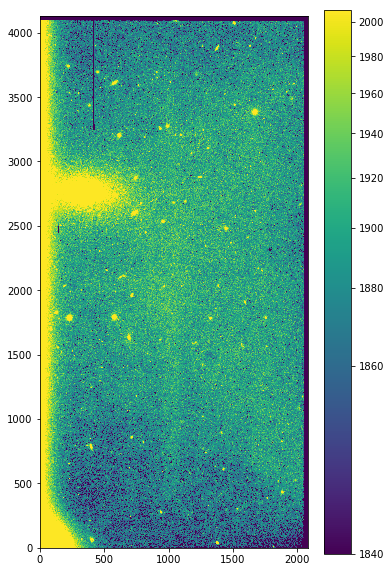

In [45]:
show_image(ccddata_g, 95)  # The 95 shifts the colorbar even more, which looks better than the normal sqrtstretch

Looks just the same, so looks like it accomplished the same aim but with less dependence on the FITS format.  So we will continue on with this data structure.

## Overscan and Bias 

Our first set of corrections center around removing the "bias" of the image - usually due to the voltage offset necessary to make a CCD work - along with associated pixel-by-pixel offsets due to the electronics.

### Understanding Bias and Overscan areas

Examine the ``observing_log.csv`` file.  It shows that the first several images are called "bias".  That seems like a good place to start! Lets try examining one - both the image itself and its header.

SIMPLE  =                    T  / STANDARD FITS                                 
BITPIX  =                   16  / BITS/PIXEL                                    
NAXIS   =                    2  / NUMBER OF AXES                                
NAXIS1  =                 2080  / NUMBER OF COLUMNS                             
NAXIS2  =                 4128  / NUMBER OF ROWS                                
BSCALE  =        1.0000000E+00  / PHYSICAL = BSCALE * DATA + BZERO              
BZERO   =               32768.                                                  
DATE    = '2016-01-15'          / UT Date of file creation (DD/MM/YY)           
ORIGIN  = 'California Institute of Technology'  / Palomar Observatory           
LATITUDE=              33.4000  / Latitude (degrees N)                          
LONGITUD=            -116.9000  / Longitude (degrees E)                         
TELESCOP= 'Hale 5m Telescope'   / Telescope used for observation                
FRATIO  =               7.50

/anaconda/envs/DSFP/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/anaconda/envs/DSFP/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


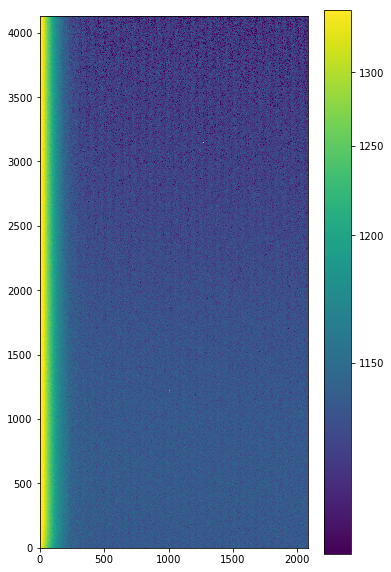

In [46]:
im1 = CCDData.read('python_imred_data/ccd.001.0.fits.gz', unit=u.count)
show_image(im1)
im1.header

Several things to note here.  First, it says it has an exposure time of zero, as expected for a bias.  There is also a big glowing strip on the left that is a few hunderd counts. This is probably an example of "amplifier glow", where the readout electronics emit light (or electronic noise) that is picked up by the CCD as it reads out.  Forrunately, this pattern, along with the other patterns evident in this image, are mostly static, so they can be removed by simply subtracting the bias.

Another thing that might not be obvious to the untrained eye is that the image dimensions are sllightly larger than a power-of-two.  This is not the size of the actual detector.  Another hint is in the header in the section called `BIASSEC`: this reveals the section of the chip that is used for "overscan" - the readout process is repeated several times past the end of the chip to characterize the average bias for that row.  Lets take a closer look at the overscan area.  Note that we do this in one of the *science* exposures because it's not visible in the bias (which is in some sense *entirely* overscan):

/anaconda/envs/DSFP/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/anaconda/envs/DSFP/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


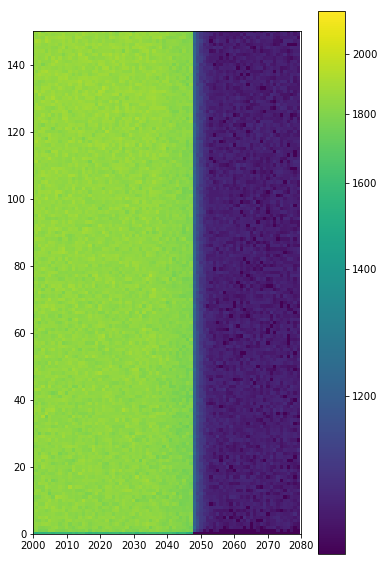

In [47]:
show_image(ccddata_g)  #plot part of the overscan region in a science image to fully make it obvious.
plt.xlim(2000,2080)
plt.ylim(0,150);

Now it is clear that the overscan region is quite different from the rest of the image.  

### Subtracting overscan

Fortunately, subtracting the overscan region is fairly trivial with the `ccdproc` package.  It has a function to do just this task.  Take a look at the docs for the function by executing the cell below.

In [49]:
ccdproc.subtract_overscan?

Of particular note is the ``fits_section`` keyword.  This seems like it might be useful because the header already includes a FITS-style "BIASSEC" keyword.  Lets try using that:

In [50]:
ccdproc.subtract_overscan(im1, fits_section=im1.header['BIASSEC'])

ValueError: operands could not be broadcast together with shapes (4128,2080) (4127,1) 

D'Oh! That didn't work.  Why not?  The error message, while a bit cryptic, provides a critical clue: the overscan region found is one pixel shorter than the actual image.  This is because the "BIASSEC" keyword in this image doesn't follow quite the convention expected for the second (vertical) dimension. So we will just manually fill in a ``fits_section`` with the correct overscan region.

In [51]:
im1.header['BIASSEC']

'[2049:2080,1:4127]'

(4128, 2080)

/anaconda/envs/DSFP/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/anaconda/envs/DSFP/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


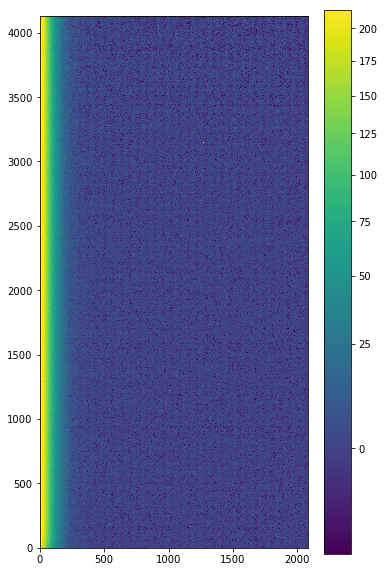

In [52]:
subed = ccdproc.subtract_overscan(im1, fits_section='[2049:2080,:]', overscan_axis=1)
show_image(subed)
subed.shape

While the image at first glance looks the same, looking at the color bar now reveals that it is centered around ``0`` rather than ~``1100``.  So we have sucessfully subtracted the row-by-row bias using the overscan region.

However, the image still includes the overscan region.  To remove that, we need to trim the image.  The FITS header keyword ``DATASEC`` is typically used for this purpose, and we can use that here to trim off the overscan section:

(4128, 2048)

/anaconda/envs/DSFP/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/anaconda/envs/DSFP/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


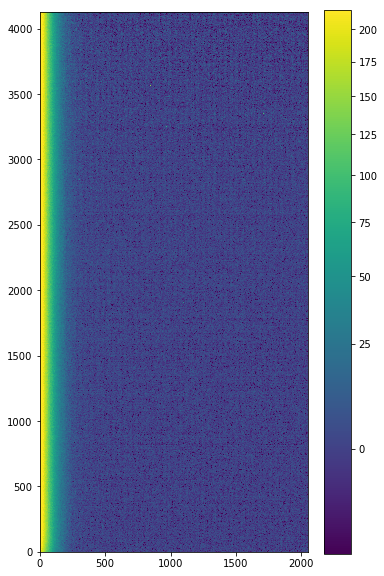

In [53]:
trimmed = ccdproc.trim_image(subed, fits_section=subed.meta['DATASEC']) #Datasec= data section
show_image(trimmed)
trimmed.shape

Looking closely, though we see another oddity: even with the trimming done above, it is still not the dimensions the LFC specs say the CCD should be (2048 × 4096 pixels).  The vertical direction still has excess pixels.  Lets look at these in the science image:

/anaconda/envs/DSFP/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/anaconda/envs/DSFP/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


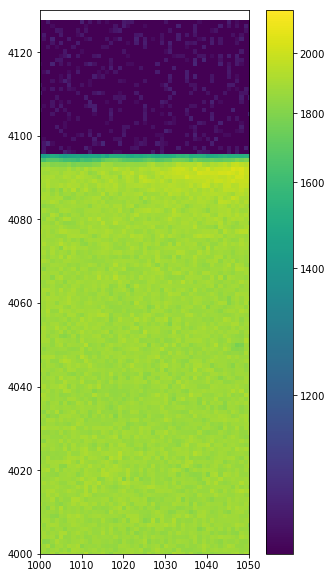

In [54]:
show_image(ccddata_g)
plt.xlim(1000,1050)
plt.ylim(4000,4130);

It appears as though there is a *second* overscan region along the columns.  We could conceivably choose to use that overscan region as well, but we should be suspicious of this given that it is not part of the `BIASSEC` mentioned in the header, and is included in `DATASEC`.  So it seems like it might be safer to just trim this region off and trust in the bias to remove the column-wise variations.

We know we need to apply this correction to *every* image, so to make the operations above repeatable easily, we move them into a single function to perform the overscan correction, which we will call later in the notebook:

In [55]:
def overscan_correct(image):
    """
    Subtract the row-wise overscan and trim the non-data regions.
    
    Parameters
    ----------
    image : CCDData object
        The image to apply the corrections to
        
    Returns
    -------
    CCDData object
        the overscan-corrected image
    """
    subed = ccdproc.subtract_overscan(image, fits_section='[2049:2080,:]', overscan_axis=1)  #corrects for the overscan column
    trimmed = ccdproc.trim_image(subed, fits_section='[1:2048,1:4096]')  #trims the overscan top rows
    return trimmed

### Exercise 

Both bias images and overscan regions contain read noise (since they are read with the same electronics as everything else). See if you can determine the read noise (in counts) of this chip using the images we've examined thus far.  Compare to the [LFC spec page](http://www.astro.caltech.edu/palomar/observer/200inchResources/lfcspecs.html) and see if you get the same answer as they do (see the table in section 3 - this image is from CCD #0).

Ummm not sure how to get it, something to do with gain? Yes! 
                      # of electrons per pixel
          gain   =  --------------------------
                      # of counts per pixel 
            
            The answer is 11 electrons.

### Combining and applying a "master bias"

The overscan is good at removing the bias along its scan direction, but will do nothing about pixel-specific bias variations or readout phenomena that are constant per-readout but spatially varying (like the "glow" on the left edge of the image that we saw above).  To correct that we will use a set of bias frames and subtract them from the images.  Before we can do this, however, we need to combine the biases together into a "master bias".  Otherwise we may simply be adding more noise than we remove, as a single bias exposure has the same noise as a single science exposure.

Look at the ``observing_log.csv`` file.  It shows you which files are biases.  The code below conveniently grabs them all into a single python list:

In [56]:
biasfns = glob('python_imred_data/ccd.00?.0.fits.gz')
biasfns

['python_imred_data/ccd.001.0.fits.gz',
 'python_imred_data/ccd.002.0.fits.gz',
 'python_imred_data/ccd.003.0.fits.gz',
 'python_imred_data/ccd.004.0.fits.gz',
 'python_imred_data/ccd.005.0.fits.gz',
 'python_imred_data/ccd.006.0.fits.gz']

Now we both load these images into memory *and* apply the overscan correction in a single step.  

In [57]:
biases = [overscan_correct(CCDData.read(fn, unit=u.count)) for fn in biasfns]

In [ ]:
# The above cell uses Python's "list comprehensions", which are faster and more 
# compact than a regular for-loop.  But if you have not seen these before, 
# it's useful to know they are exactly equivalent to this:

# biases = []
# for fn in biasfns:
#     im = overscan_correct(CCDData.read(fn, unit=u.count))
#     biases.append(im)

Now that we have all the bias images loaded and overscan subtracted, we can combine them together into a single combined (or "master") bias.  We use the `ccdproc.Combiner` class to do median combining (although it supports several other combining algorithms):

In [58]:
bias_combiner = ccdproc.Combiner(biases)
master_bias = bias_combiner.median_combine()

/anaconda/envs/DSFP/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/anaconda/envs/DSFP/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


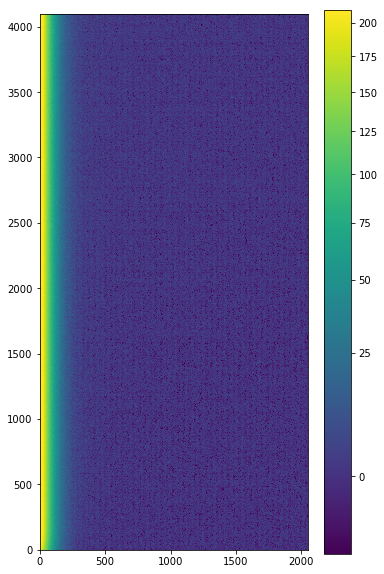

In [59]:
show_image(master_bias)

Not too much exciting there to the eye... but it should have better noise properties than any of the biases by themselves.  Now lets do the final step in the bias process and try subtracting the bias from the science image.  Lets look at the docstring for `ccdproc.subtract_bias`

In [60]:
ccdproc.subtract_bias?

Looks pretty straightforward to use!  Just remember that we have to overscan-correct the science image *before* we apply the bias:

/anaconda/envs/DSFP/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/anaconda/envs/DSFP/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


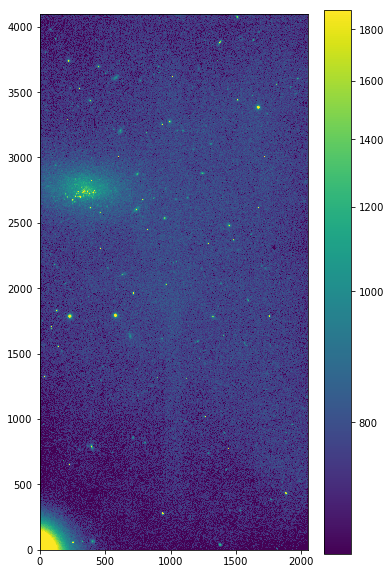

In [61]:
ccddata_g_corr = overscan_correct(ccddata_g)
ccd_data_g_unbiased = ccdproc.subtract_bias(ccddata_g_corr, master_bias)
show_image(ccd_data_g_unbiased, 10, 99.8)

Hark!  The bias level is gone, as is the glowing strip on the left.  Two artifacts down.  It is now also quite evident that there is some kind of interesting astronomical object to the center-left...

### Exercise 

Opinions vary on the best way to combine biases. Try comparing the statistics of a bias made using the above procedure and one using a simple average (which you should be able to do with `bias_combiner`).  Which one is better?  Discuss with your neighbor when you might like one over the other.

In [62]:
***stopped here***

SyntaxError: invalid syntax (<ipython-input-62-52a0a898246f>, line 1)

## Flats

The final image correction we will apply is a flat. Dividing by a flat removes pixel-by-pixel sensitivity variations, as well as some imperfections in instrument optics, dust on filters, etc. Different flats are taken with each filter, so lets look in the ``observing_log.csv`` to see which images are flats for the g-band filter:

In [ ]:
flat_g_fns = glob('python_imred_data/ccd.01[4-6].0.fits.gz')
flat_g_fns

Now we load these files like we did the biases, applying both the overscan *and* bias corrections:

In [ ]:
# These steps could all be one single list comprehension. However,
# breaking them into several lines makes it much clearer which steps
# are being applied. In practice the performance difference is
#  ~microseconds, far less than the actual execution time for even a
# single image

flats_g = [CCDData.read(fn, unit=u.count) for fn in flat_g_fns]
flats_g = [overscan_correct(flat) for flat in flats_g]
flats_g = [ccdproc.subtract_bias(flat, master_bias) for flat in flats_g]
show_image(flats_g[0], 90)

Inspecting this bias shows that it has far more counts than the science image, which is good because that means we have I higher S/N than the science.  It clearly shows the cross-shaped imprint in the middle that is also present in the science image, as well as vignetting near the bottom).

Now we combine the flats like we did with the biases to get a single flat to apply to science images.

In [ ]:
flat_g_combiner = ccdproc.Combiner(flats_g)
# feel free to choose a different combine algorithm if you developed a preference in the last exercise
combined_flat_g = flat_g_combiner.median_combine()

show_image(combined_flat_g, 90)

Now we can do the final correction to our science image: dividing by the flat. `ccdproc` provides a function to do that, too:

In [ ]:
ccdproc.flat_correct?

Note that this includes, by default, automatically normalizing the flat so that the resulting image is close to the true count rate, so there's no need to manually re-normalize the flat (unless you want to apply it many times and don't want to re-compute the normalization).  Lets see what happens when we apply the flat to our science image:

In [ ]:
ccd_data_g_flattened = ccdproc.flat_correct(ccd_data_g_unbiased, combined_flat_g)
show_image(ccd_data_g_flattened, 10, 99.5)

Now we're in business!  This now looks like an astronomical image of a galaxy and various objects around it, aside from some residual amp glow (discussed below in the "Advanced Exercise").

### Exercise 

We still haven't gotten quite rid of the glow.  It seems there is a slight residual glow in the strip on the left, and a quite prominent glow to the lower-left.

The lower-left glow is apparently time-dependent - that is, it is absent in the biases (0 sec exposure), weak in the flats (70 sec exposure), but much stronger in the science images (300 sec).  This means it is probably due to amplifier electronics that emit a continuous glow even when not reading out. That's an annoying thing about semiconductors: while they are great light absorbers but also great emmitters!  Oh well, at least in means our electricity bills are getting cheaper...

In any event, this means the only way to correct for this glow is to use a "dark" in place of a bias.  A dark is an exposure of the same *time* as the target exposure, but with the camera shutter closed. This exposure should then capture the full amplifier glow for a given exposure time.  You may have noticed the data files included a `darks` directory. If you look there you'll see several images, including dark exposures of times appropriate for our images. They have overlapping exposure  numbers and no log, because they were taken on a *different* night as the science data, but around the same time.  So you will have to do some sleuthing to figure out which ones to use.

Once you've figured this out, try applying the darks to the images in the same way as the biases and see if you can get rid of the remaining glow.  If you get this working, you can use those images instead of the ones derived above for the "Photometry" section.

### Advanced Exercise 

Due to time constraints, the above discussion has said little about uncertainties. But there is enough information in the images above to compute running per-pixel uncertainties. See if you can do this, and attach them to the final file as the ``ccd_data_g_flattened.uncertainty`` attribute (see the [nddata](http://docs.astropy.org/en/stable/nddata/index.html) and [CCDData](http://docs.astropy.org/en/stable/api/astropy.nddata.CCDData.html) docs for the details of how to store the *type* of uncertainty).

## Photometry 

After the above reductions, opinions begin to diverge wildly on the best way to reduce data. Many, many papers have been written on the right way to do photometry for various conditions or classes of objects.  It is an area both of active research and active code development.  It is *also* the subject of many of the lectures this week.

Hence, this final section is not meant to be in any way complete, but rather meant to demonstrate a few ways you might do certain basic photometric measurements in Python. For this purpose, we will rely heavily on [photutils](https://photutils.readthedocs.org), the main Astropy package for doing general photometry.

### Background Estimation 

Before any photometric measurements can be made of any object, the background flux must be subtracted. In some images the background is variable enough that fairly complex models are required.  In other cases, this is done locally as part of the photometering, although that can be problematic in crowded fields.  But for many purposes estimating a single background for the whole image is sufficient, and it is that case we will consider here.

Phutils has [several](https://photutils.readthedocs.io/en/stable/background.html) background-estimation algorithms available.  Here we will use an algorithm meant to estimate the mode of a distribution relatively quickly in the presence of outliers (i.e., the background in a typical astronomical image that's not too crowded with sources):

In [ ]:
from astropy.stats import SigmaClip

bkg_estimator = photutils.ModeEstimatorBackground(sigma_clip=SigmaClip(sigma=3.))
# Note: for some versions of numpy you may need to do ``ccd_data_g_flattened.data`` in the line below
bkg_val = bkg_estimator.calc_background(ccd_data_g_flattened)
bkg_val

Now we can subtract that from the reduced science image.  Note that the units have to match:

In [ ]:
ccd_data_g_bkgsub = ccd_data_g_flattened.subtract(bkg_val*u.count)
show_image(ccd_data_g_bkgsub)

Doesn't look too different from the last one by eye... which is expected because it's just a shift in the 0-level. But now seems like a good time to zoom in on that galaxy in the center-left:

### Finding Notable Objects

In [ ]:
show_image(ccd_data_g_bkgsub, 12, 99.9, figsize=(12, 10))
plt.xlim(0, 1000)
plt.ylim(2200, 3300)

Aha!  It's a Local Group galaxy, because otherwise you wouldn't be able to see individual stars like that. Lets see if we can identify it.  Lets see where the telescope was pointed:

In [ ]:
ccddata_g.header['RA'], ccddata_g.header['DEC']

Knowing that this location in the image is pretty close to the center, we can try using NED (the NASA/IPAC Extragalactic Database) to identify the object.  Go to [NED's web site](http://ned.ipac.caltech.edu/) and click the "near position" search.  Enter in the coordinates, and hit search. You'll see plenty of objects, but only one that's actually a Local Group galaxy.

For comparison purposes, lets also look at this field in the Sloan Digital Sky Survey.  Go to the [SDSS Sky Navigate Tool](http://skyserver.sdss.org/dr13/en/tools/chart/navi.aspx), and enter in the same coordinates as above.  You'll land right on a field that should look like our target galaxy.  This means we can use the SDSS as a comparison to see if our photometric measurements make any sense.  Keep that window open for reference later on.

For now, we note two objects that are more compact than the Local Group galaxy and therefore more amenable to a comparison with SDSS: the two background galaxies that are directly to the right of the Local Group object.

### Aperture Photometry

The simplest form of photometry is simply drawing apertures (often circular) around an object and counting the flux inside that aperture.  Since this process is so straightforward, we will us it as a sanity check for comparing our image to the SDSS.

First, we need to pick an aperture.  SDSS provides several aperture photometry measurements, but the easiest to find turns out to be 3" diameter apertures (available on SDSS as "FIBERMAG").  We need to compute how many *pixels* for our image are in a 3" aperture.  Lets choose to true the FITS headers, which give a plate scale.

In [ ]:
ccddata_g.header

Note the "SECPIX1"/"SECPIX2" keywords, which give the number of arcseconds per pixel.  While this is relatively straightforward, we e can use `astropy.units` machinery in a way that makes it foolproof (i.e., keeps you from getting pixel/arcsec or arcsec/pixel confused):

In [ ]:
scale_eq = u.pixel_scale(ccddata_g.header['SECPIX1']*u.arcsec/u.pixel)
fibermag_ap_diam = (3*u.arcsec).to(u.pixel, scale_eq)
fibermag_ap_diam

Now we can use this to define a photutils `CircularAperture` object. These objects also require positions, so we'll pick the positions of the two objects we identified above:

In [ ]:
positions = [(736., 2601.5), (743., 2872.)]
apertures = photutils.CircularAperture(positions, r=fibermag_ap_diam.value/2)

Conveniently, these apertures can even plot themselves:

In [ ]:
show_image(ccd_data_g_bkgsub, 12, 99.9, figsize=(6, 10))
apertures.plot(color='red')
plt.xlim(600, 800)
plt.ylim(2530, 2920)

And indeed we see they are centered on the right objects.  

Now we simply perform photometry on these objects using `photutils.aperture_photometry`

In [ ]:
photutils.aperture_photometry?

While it has many options, the defaults are probably sufficient for our needs right now:

In [ ]:
apphot = photutils.aperture_photometry(ccd_data_g_bkgsub, apertures)
apphot

The results given are *fluxes* in units of counts, which we can convert to "instrumental" magnitudes and put into the table:

In [ ]:
apphot['aperture_mags'] = u.Magnitude(apphot['aperture_sum'])
apphot

While the value of these magnitudes is instrument-specific, the *difference* of these magnitudes should match the difference between any other instrument, including the SDSS. Find the two objects in the navigate view.  When you click on one of them in the window, you can choose "explore" on the right, and then the "PhotoObj" link on the left sidebar in the explore window that comes up. Record "fiberMag_g" row in that table.  Repeat for the other galaxy, and compare the difference that you compute below.  

In [ ]:
apphot['aperture_mags'][1] - apphot['aperture_mags'][0]

You should get the SDSS and your computed difference to be within ~0.001 mags if all went well in the previous steps. Guess we're on the right track!

### Exercise 

The `astroquery` package contains a sub-package `astroquery.sdss` that can be used to programatically search the SDSS for objects.  See if you can use that to automate the process we followed above to compare SDSS and our image.

Note: you may need to install `astroquery` the same way as you did `ccdproc` or `photutils` (see the top of this notebook).

To go one step further, try using the SDSS to *calibrate* (at least, roughly) our measurements.  This will require identifying matching objects in the field (ideally fairly bright stars) and using them to compute the instrumental-to-$g$-band offset.  See if you get magnitudes to match the SDSS on other objects.

### Source Detection using Thresholding

As with photometry, source-finding as a complex subject.  Here we overview a straightforward algorithm that `photutils` provides to find heterogeneous objects in an image.  Note that this is *not* optimal if you are only looking for stars.  `photutils` provides several star-finders that are better-suited for that problem (but are not covered further here).

Have a look at the options to the relevant `photutils` function:

In [ ]:
photutils.detect_sources?

The thresholding algorithm here is straightforward and fairly efficient interpretation, but it requires a threshold above which "isolated" pixels are considered separate objects. `photutils` provides automated ways to do this, but for now we will do it manually:

In [ ]:
plt.hist(ccd_data_g_bkgsub.data.flat, histtype='step',
         bins=100, range=(-100, 200))
plt.xlim(-100, 200)
plt.tight_layout()

Simply eye-balling this histogram reveals that the background fluctuations are at the level of ~20 counts.  So if we want a 3-sigma threshold, we use 60.  We also, somewhat arbitrary, require at last 5 pixels for a source to be included:

In [ ]:
ccd_data_g_bkgsub.shape

In [ ]:
# as above, for some numpy versions you might need a `.data` to get this to work
srcs = photutils.detect_sources(ccd_data_g_bkgsub, 60, 5)

The resulting object also has some utilities to help plot itself:

In [ ]:
plt.figure(figsize=(8, 16))
plt.imshow(srcs, cmap=srcs.cmap('#222222'), origin='lower')

We can clearly see our two objects from before standing out as distinct sources. Lets have a closer look:

In [ ]:
plt.figure(figsize=(6, 10))
plt.imshow(srcs, cmap=srcs.cmap('#222222'), origin='lower')
apertures.plot(color='red')
plt.xlim(600, 800)
plt.ylim(2530, 2920)

Now lets try to figure out which of the many objects in the source table are ours, and try making measurements of these objects directly from these threshold maps:

In [ ]:
# if you had to do `.data` above, you'll need to add it here too to get all the cells below to work
src_props = photutils.source_properties(ccd_data_g_bkgsub, srcs)

In [ ]:
srcid = np.array(src_props.id)
x = src_props.xcentroid.value
y = src_props.ycentroid.value

src0_id = srcid[np.argmin(np.hypot(x-positions[0][0] , y-positions[0][1]))]
src1_id = srcid[np.argmin(np.hypot(x-positions[1][0] , y-positions[1][1]))]
msk = np.in1d(srcid, [src0_id, src1_id])

x[msk], y[msk]

Now sanity-check that they are actually the correct objects:

In [ ]:
plt.figure(figsize=(8, 16))
plt.imshow(srcs, cmap=srcs.cmap('#222222'), origin='lower')

plt.scatter(x[msk], y[msk], c='r', s=150, marker='*')

plt.xlim(600, 800)
plt.ylim(330+2200, 720+2200)

Now that we've identified them, we can see all the information the ``photutils.source_properties`` computes.  The one thing it does not do is instrumental magnitudes, so we add that manually.

In [ ]:
src_tab = src_props.to_table()
if src_tab['source_sum'].unit == u.count:
    src_tab['source_mags'] = u.Magnitude(src_tab['source_sum'])
else:
    # this is the case for if you had to do the ``.data`` work-around in the ``source_properties`` call
    src_tab['source_mags'] = u.Magnitude(src_tab['source_sum']*u.count)

src_tab[msk]

We see quite a number of properties, but most notably the magnitudes are quite different. This is to be expected since the effective "aperture" is quite different, but it may or may not be desired.  What is "desired", however, is left as an exercise to the reader!

### Exercise 

Try combining the two sections above.  Given the centers the source-detection stage finds, try doing aperture photometry.

If you like, compare to the SDSS and see if you get similar answers (`astroquery` will be an even bigger help in this stage). At this point you might be angry that in the last exercise you had to do it manually.  Fair enough... but no pain no gain!

### Exercise 

Experiment with `photutils.deblend_sources`.  Can you deblend some of the individual stars that are visible in the Local Group Galaxy?  Compare to what the SDSS provides.

# Wrap-up 

That's it for this whirlwind overview of basic image reductions in Python and Astropy.  A few more exercises are below if you're looking for more, but there's plenty more later in the week!

### Exercise 

If you look at the data directory, you'll see that, in addition to the $g$-band science image we've been looking at, there's an $i$-band image.  Try following the above reduction steps to extract that as well. Use this to get aperture photometry-based *colors* for some objects. (hint: you'll need to do the calibration against SDSS to make this work...)